#**Практическое задание №1**

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 18.8 MB/s eta 0:00:00

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive

In [ ]:
!unzip /content/drive/MyDrive/train_test.zip

Archive:  /content/drive/MyDrive/train_test.zip
   creating: train_test/
  inflating: __MACOSX/._train_test   
  inflating: train_test/train.npz    
  inflating: __MACOSX/train_test/._train.npz  
  inflating: train_test/test.npz     
  inflating: __MACOSX/train_test/._test.npz  

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import gdown
from torch.utils import data
import torch
from torch import nn
import torchmetrics
import torchvision
from tqdm.auto import tqdm
import albumentations as A
import albumentations.pytorch.transforms
from sklearn.model_selection import train_test_split
import glob
from typing import List
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import IPython.display

BATCH_SIZE = 32
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

#LBL1 аугментация
augmentations = [
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.pytorch.transforms.ToTensorV2(),
]

common_transforms = [
    A.pytorch.transforms.ToTensorV2(),
]

MyTrainTransform = A.ReplayCompose(augmentations)
MyValidTransform = A.ReplayCompose(common_transforms)

def my_train_transform(image):
    return MyTrainTransform(image=np.array(image))["image"]


def my_valid_transform(image):
    return MyValidTransform(image=np.array(image))["image"]

In [30]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

In [31]:
class Dataset:

    def __init__(self, name, mode='test', transform=None):
        self.name = name
        self.transform = transform
        self.is_loaded = False

        if glob.glob(f'{name}.npz'):
            print(f'Loading dataset {self.name} from npz.')
            np_obj = np.load(f'{name}.npz')
        else:
            url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
            output = f'{name}.npz'
            gdown.download(url, output, quiet=False)
            print(f'Loading dataset {self.name} from npz.')
            np_obj = np.load(f'{name}.npz')

        images = np_obj['data']
        labels = np_obj['labels']

        #LBL2 разбиение выборки на тренировочную/валидационную
        train_images, valid_images, train_labels, valid_labels = train_test_split(
            images, labels, test_size=0.2, random_state=42, stratify=labels
        )

        if mode == 'train':
            self.images = train_images
            self.labels = train_labels
        elif mode == 'valid':
            self.images = valid_images
            self.labels = valid_labels
        else:
            self.images = images
            self.labels = labels

        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

    def random_image_from_class(self, label: int):
        images_per_class = self.n_files // 9
        start_class_indexes = images_per_class * label
        end_class_indexes = start_class_indexes + images_per_class
        random_image_index = np.random.randint(start_class_indexes, end_class_indexes)
        return self.image(random_image_index)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = self.image(index)
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)
        return image, label

In [32]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=9, first_unfrozen=0):
        super(CustomResNet50, self).__init__()
        weights = torchvision.models.ResNet50_Weights.DEFAULT
        self.model = torchvision.models.resnet50(weights=weights)

        for child in list(self.model.children())[:first_unfrozen]:
            for param in child.parameters():
                param.requires_grad = False

        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 1024),
            nn.ReLU(),

            nn.Linear(1024, 1024),
            nn.ReLU(),

            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class Model:

    def __init__(self, num_epochs=10):
      self.num_epochs = num_epochs
      self.model = CustomResNet50(num_classes=9, first_unfrozen=7).to(DEVICE)
      self.loss_fn = torch.nn.CrossEntropyLoss().to(DEVICE)
      self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-2)

    def save(self, name: str):
        torch.save(self.model.state_dict(), f'/content/drive/MyDrive/{name}.pth')

    def load(self, name: str):
        model_path = f'{name}.pth'
        file_id = "1ZjcTs0zoFlwt-RVNE1FusPYYKcyE9sCe"
        gdown.download(f"https://drive.google.com/uc?id={file_id}", model_path, quiet=False)

        sd = torch.load(
            model_path,
            map_location=torch.device(DEVICE),
            weights_only=True,
        )
        self.model.load_state_dict(sd)


    def train(self, train: data.DataLoader, valid: data.DataLoader):
        best_validation_accuracy = 0.0

        history = {
            "train_loss": [],
            "train_accuracy": [],
            "validation_accuracy": []
        }

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode="max",
            factor=0.1,
            patience=2,
            threshold=0.01,
            threshold_mode="rel",
            cooldown=0,
            min_lr=1e-6
        )
    
        lr_scheduler_config = {
            "scheduler": lr_scheduler,
            "interval": "epoch",
            "frequency": 1,
            "monitor": "valid_accuracy"
        }
        
        for e in range(self.num_epochs):
            self.model.train()
            train_loss = []

            train_accuracy_metric = torchmetrics.Accuracy(
                task="multiclass",
                num_classes=9,
            ).to(DEVICE)

            progress_train = tqdm(
                total=len(train),
                desc=f"Epoch {e}",
                leave=False,
            )
            for x_batch, y_batch in train:
                x_batch = x_batch.to(DEVICE).float()
                y_batch = y_batch.to(DEVICE)

                p_batch = self.model(x_batch)
                loss = self.loss_fn(p_batch, y_batch)
                train_loss.append(loss.detach())

                train_accuracy_metric.update(p_batch, y_batch)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                progress_train.update()
            progress_train.close()

            train_loss = torch.stack(train_loss).mean()
            train_accuracy = train_accuracy_metric.compute()
            #LBL4 Вывод различных показателей в процессе обучения
            print(
                f"Epoch {e},",
                f"train_loss: {train_loss.item():.8f},",
                f"train_accuracy: {train_accuracy:.4f}"
            )

            history["train_loss"].append(train_loss.item())
            history["train_accuracy"].append(train_accuracy.item())

            train_accuracy_metric.reset()

            self.model.eval()
            progress_valid = tqdm(
                total=len(valid),
                desc=f"Validation Epoch {e}",
                leave=False,
            )

            valid_accuracy_metric = torchmetrics.Accuracy(
                task="multiclass",
                num_classes=9,
            ).to(DEVICE)

            #LBL2 валидация
            for x_batch, y_batch in valid:
                x_batch = x_batch.to(DEVICE).float()
                y_batch = y_batch.to(DEVICE)

                with torch.no_grad():
                    p_batch = self.model(x_batch)

                valid_accuracy_metric.update(p_batch, y_batch)

                progress_valid.update()
            progress_valid.close()

            validation_accuracy = valid_accuracy_metric.compute()
            #LBL4 Вывод различных показателей в процессе обучения
            print(
                f"Epoch {e},",
                f"validation_accuracy: {validation_accuracy:.4f}",
            )
            history["validation_accuracy"].append(validation_accuracy.item())

            #LBL3 Автоматическое сохранение модели при обучении
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                self.save('best_tuned_model')
                print("Model saved at best_model")

            valid_accuracy_metric.reset()

            lr_scheduler.step(validation_accuracy)
        
        if history["validation_accuracy"][-1] != best_validation_accuracy:
            self.save('last_version_tunde_model')
            print("Model saved at last_version_model")

        #LBL5 Построение графиков, визуализирующих процесс обучения
        self.plot_training_history(history)
        return self.model

    def plot_training_history(self, history):
        epochs = range(1, len(history["train_loss"]) + 1)

        fig, axes = plt.subplots(2, 1, figsize=(10, 10))

        axes[0].plot(epochs, history["train_loss"], label="Train Loss", marker='o')
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].set_title("Training Loss Over Epochs")
        axes[0].legend()
        axes[0].grid(True)

        axes[1].plot(epochs, history["train_accuracy"], label="Train Accuracy", marker='o')
        axes[1].plot(epochs, history["validation_accuracy"], label="Validation Accuracy", marker='o')
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].set_title("Training and Validation Accuracy Over Epochs")
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()

        plt.show()

    def test_on_dataset(self, dataset: Dataset):
        dl_test = data.DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            drop_last=False,
        )

        all_predictions = []
        misclassified_indices = {i: [] for i in range(9)}

        with torch.no_grad():
            self.model.eval()
            progress_test = tqdm(
                total=len(dl_test),
                desc=f"Test",
                leave=False,
            )

            accuracy_metric = torchmetrics.Accuracy(
                task="multiclass",
                num_classes=9,
            ).to(DEVICE)

            for batch_idx, (x_batch, y_batch) in enumerate(dl_test):
                batch_indices = range(batch_idx * len(x_batch), batch_idx * len(x_batch) + len(x_batch))
                x_batch = x_batch.to(DEVICE).float()
                y_batch = y_batch.to(DEVICE)

                p_batch = self.model(x_batch.permute(0, 3, 1, 2))

                predicted_labels = p_batch.argmax(dim=1)
                all_predictions.extend(predicted_labels.cpu().numpy())

                for (pred, label, idx) in zip(predicted_labels.cpu().numpy(), y_batch.cpu().numpy(), batch_indices):
                    if pred != label:
                        misclassified_indices[label].append((idx, pred))
                    
                accuracy_metric.update(p_batch, y_batch)
                progress_test.update()
            progress_test.close()

            test_accuracy = accuracy_metric.compute()
            print(
                f"test_accuracy: {test_accuracy:.4f}",
            )
            accuracy_metric.reset()

        return all_predictions, misclassified_indices

    def test_on_image(self, img: np.ndarray):
        img = torch.tensor(img).unsqueeze(0).to(DEVICE).float()
        img = img.permute(0, 3, 1, 2)
        with torch.no_grad():
            self.model.eval()
            p = self.model(img)

        return p

In [41]:
#LBL6 Построение матрицы ошибок, оценивание чувствительности и специфичности модели
def evaluate_model(all_preds, all_labels, cmap='viridis'):
    cm = confusion_matrix(all_labels, all_preds)
    display = ConfusionMatrixDisplay(confusion_matrix=cm)
    display.plot(cmap=cmap)
    plt.title("Confusion Matrix")
    plt.show()

    sensitivity = []
    specificity = []

    for i in range(len(cm)):
        TP = cm[i, i]
        FN = sum(cm[i, :]) - TP
        FP = sum(cm[:, i]) - TP
        TN = cm.sum() - (TP + FN + FP)

        sensitivity.append(TP / (TP + FN) if (TP + FN) > 0 else 0)
        specificity.append(TN / (TN + FP) if (TN + FP) > 0 else 0)

    print(f"Средняя чувствительность: {np.mean(sensitivity):.4f}")
    print(f"Средняя специфичность: {np.mean(specificity):.4f}")

In [35]:
ds_train = Dataset('train', mode='train', transform=my_train_transform)
ds_valid = Dataset('train', mode='valid', transform=my_valid_transform)

dl_train = data.DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)
dl_valid = data.DataLoader(
    ds_valid,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

Loading dataset train from npz.
Done. Dataset train consists of 14400 images.
Loading dataset train from npz.
Done. Dataset train consists of 3600 images.


Epoch 0:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 0, train_loss: 0.33708522, train_accuracy: 0.9004


Validation Epoch 0:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 0, validation_accuracy: 0.9728
Model saved at best_model


Epoch 1:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 1, train_loss: 0.10133694, train_accuracy: 0.9666


Validation Epoch 1:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1, validation_accuracy: 0.9817
Model saved at best_model


Epoch 2:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 2, train_loss: 0.06978660, train_accuracy: 0.9771


Validation Epoch 2:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2, validation_accuracy: 0.9839
Model saved at best_model


Epoch 3:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 3, train_loss: 0.05533116, train_accuracy: 0.9824


Validation Epoch 3:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3, validation_accuracy: 0.9878
Model saved at best_model


Epoch 4:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 4, train_loss: 0.04128153, train_accuracy: 0.9869


Validation Epoch 4:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4, validation_accuracy: 0.9861


Epoch 5:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 5, train_loss: 0.03724325, train_accuracy: 0.9881


Validation Epoch 5:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5, validation_accuracy: 0.9883
Model saved at best_model


Epoch 6:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 6, train_loss: 0.01931176, train_accuracy: 0.9940


Validation Epoch 6:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 6, validation_accuracy: 0.9914
Model saved at best_model


Epoch 7:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 7, train_loss: 0.01501615, train_accuracy: 0.9953


Validation Epoch 7:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 7, validation_accuracy: 0.9917
Model saved at best_model


Epoch 8:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 8, train_loss: 0.01517808, train_accuracy: 0.9942


Validation Epoch 8:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 8, validation_accuracy: 0.9942
Model saved at best_model


Epoch 9:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 9, train_loss: 0.01520443, train_accuracy: 0.9950


Validation Epoch 9:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 9, validation_accuracy: 0.9933


Epoch 10:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 10, train_loss: 0.01358249, train_accuracy: 0.9949


Validation Epoch 10:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 10, validation_accuracy: 0.9917


Epoch 11:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 11, train_loss: 0.01214617, train_accuracy: 0.9961


Validation Epoch 11:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 11, validation_accuracy: 0.9922


Epoch 12:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 12, train_loss: 0.01061684, train_accuracy: 0.9970


Validation Epoch 12:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 12, validation_accuracy: 0.9925


Epoch 13:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 13, train_loss: 0.01278020, train_accuracy: 0.9956


Validation Epoch 13:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 13, validation_accuracy: 0.9922


Epoch 14:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 14, train_loss: 0.01060766, train_accuracy: 0.9962


Validation Epoch 14:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 14, validation_accuracy: 0.9922


Epoch 15:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 15, train_loss: 0.01001813, train_accuracy: 0.9967


Validation Epoch 15:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 15, validation_accuracy: 0.9925


Epoch 16:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 16, train_loss: 0.00824504, train_accuracy: 0.9969


Validation Epoch 16:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 16, validation_accuracy: 0.9933


Epoch 17:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 17, train_loss: 0.00834645, train_accuracy: 0.9977


Validation Epoch 17:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 17, validation_accuracy: 0.9939


Epoch 18:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 18, train_loss: 0.01130992, train_accuracy: 0.9961


Validation Epoch 18:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 18, validation_accuracy: 0.9925


Epoch 19:   0%|          | 0/450 [00:00<?, ?it/s]

Epoch 19, train_loss: 0.00916196, train_accuracy: 0.9971


Validation Epoch 19:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 19, validation_accuracy: 0.9933
Model saved at last_version_model


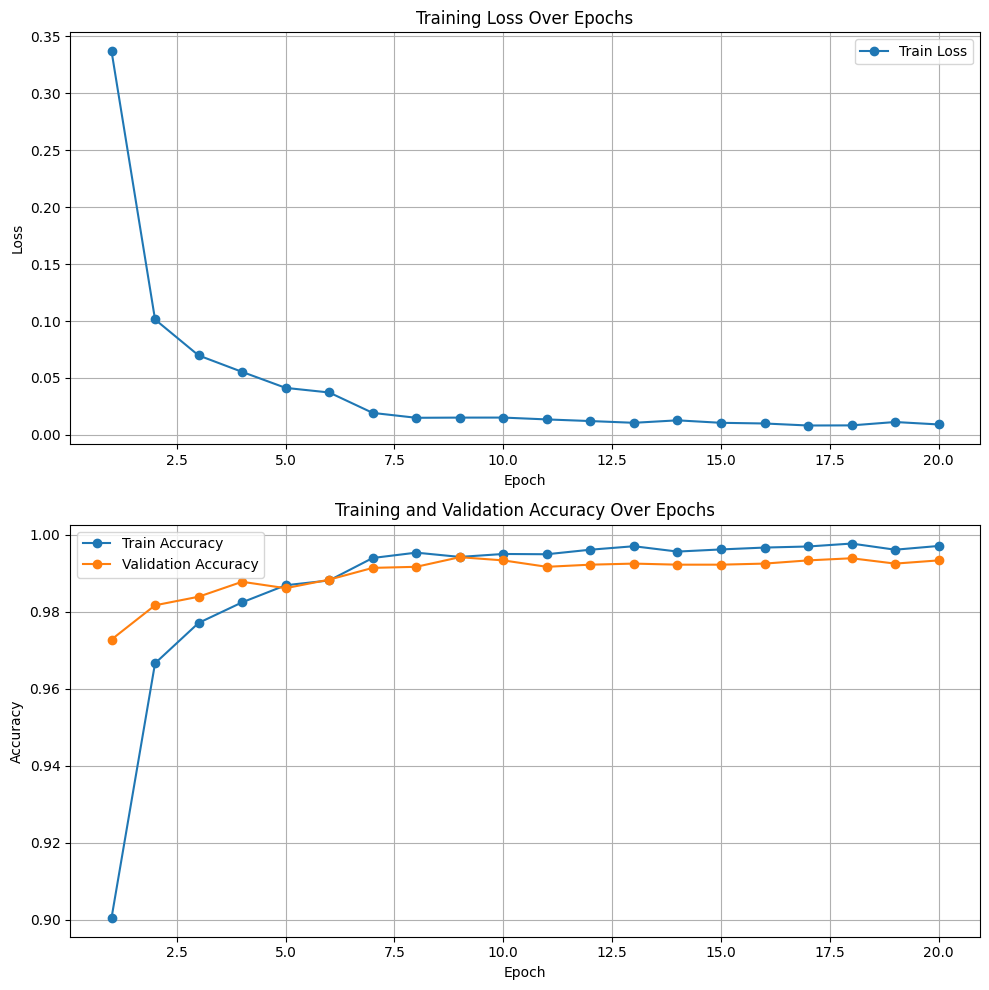

In [36]:
model = Model(num_epochs=20)
trained_model = model.train(dl_train, dl_valid)

In [62]:
model = Model()
model.load('best_model')

#LBL7 Реализация возможности дообучения модели
# model.train(dl_train, dl_valid)

Downloading...
From (original): https://drive.google.com/uc?id=1ZjcTs0zoFlwt-RVNE1FusPYYKcyE9sCe
From (redirected): https://drive.google.com/uc?id=1ZjcTs0zoFlwt-RVNE1FusPYYKcyE9sCe&confirm=t&uuid=96086ede-c446-44ed-b4b0-47dc91735849
To: /kaggle/working/best_model.pth
100%|██████████| 107M/107M [00:01<00:00, 89.3MB/s] 


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


Test:   0%|          | 0/141 [00:00<?, ?it/s]

test_accuracy: 0.9907
metrics for test:
	 accuracy 0.9907:
	 balanced accuracy 0.9907:


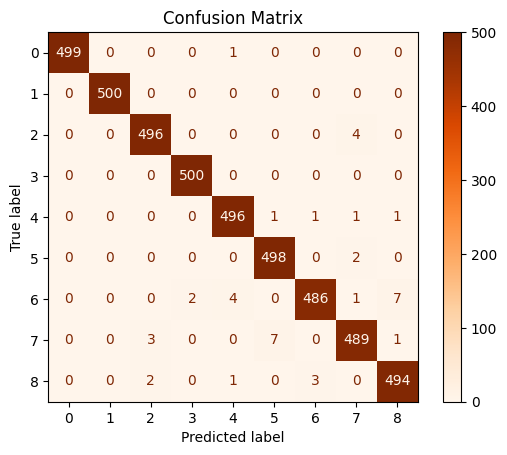

Средняя чувствительность: 0.9907
Средняя специфичность: 0.9988


In [63]:
#LBL8 визуализация результатов тестирования
d_test = Dataset('test')
pred, misclassified_indices = model.test_on_dataset(d_test)
Metrics.print_all(d_test.labels, pred, 'test')
evaluate_model(pred, d_test.labels, cmap='Oranges')

Downloading...
From (original): https://drive.google.com/uc?id=1ZjcTs0zoFlwt-RVNE1FusPYYKcyE9sCe
From (redirected): https://drive.google.com/uc?id=1ZjcTs0zoFlwt-RVNE1FusPYYKcyE9sCe&confirm=t&uuid=ee2322d6-c296-4343-bd18-54aecd9e9483
To: /kaggle/working/best.pth
100%|██████████| 107M/107M [00:00<00:00, 224MB/s] 


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


Test:   0%|          | 0/3 [00:00<?, ?it/s]

test_accuracy: 1.0000
metrics for test-tiny:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:


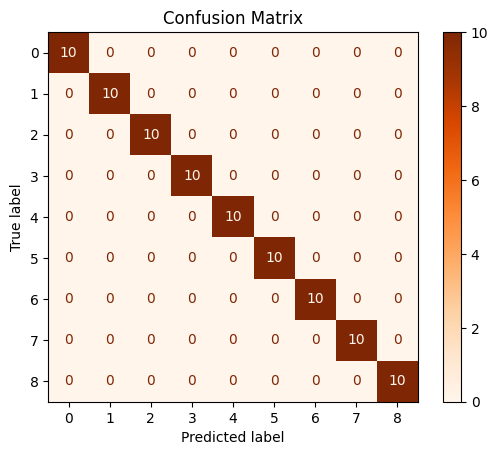

Средняя чувствительность: 1.0000
Средняя специфичность: 1.0000


In [ ]:
#LBL8 визуализация результатов тестирования
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred, misclassified_indices = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')
evaluate_model(pred, d_test_tiny.labels, cmap='Oranges')